# 8. Neural network 2

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

In [22]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [23]:
print(torch.cuda.get_device_name('cuda:0'))

NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 8.1 Automatic diffetentiation

### 8.1.4 Implementation of automatic differentiation

In [24]:
x = torch.tensor([1, -1], dtype=torch.float)
w = torch.tensor([1, 0.5], dtype=torch.float, requires_grad=True)

loss = -torch.dot(x, w).sigmoid().log()
loss.backward()
print(loss.item())
print(w.grad)

0.4740769565105438
tensor([-0.3775,  0.3775])


## 8.2 Training single layer neural network

In [25]:
def init_graph(X, dpi=100, figsize=(6,6)):
    xmin, xmax = X[:,0].min()-0.5, X[:,0].max()+0.5
    ymin, ymax = X[:,1].min()-0.5, X[:,1].max()+0.5

    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == 0)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')
    
def draw_heatmap(fig, ax, func, step=1, N=1024):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    X_ = torch.from_numpy(XY).type(dtype)
    Y_ = func(X_).detach().numpy().copy()
    C = Y_.reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

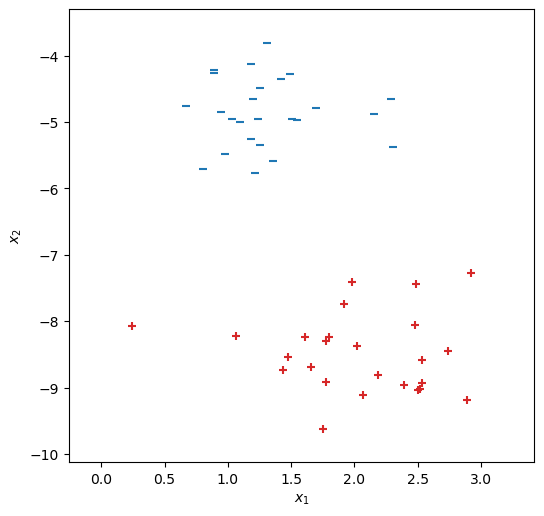

In [26]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

In [27]:
# Convert numpy object to pytorch object
from torch.utils.data import TensorDataset, DataLoader

dtype=torch.float 
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [28]:
X[:4]

tensor([[ 2.4885, -7.4323],
        [ 1.4338, -8.7279],
        [ 2.1874, -8.8029],
        [ 1.1995, -4.6490]])

In [29]:
Y[:4]

tensor([[1.],
        [1.],
        [1.],
        [0.]])

### 8.2.1 Naive implementation

In [30]:
# Data loader with batch size of 4
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Parameters
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

# SGD
H = [] # history of loss
lr = 0.01
for t in range(1000):
    sumloss = 0.
    for x, y in loader:
        y_hat = (x.matmul(w) + b).sigmoid()
        l = y * y_hat + (1 - y) * (1 - y_hat)
        loss = -l.log().sum()
        sumloss += loss.item()

        loss.backward()
        with torch.no_grad(): # Disable gradient calculation in this block
            w -= lr * w.grad
            b -= lr * b.grad
            w.grad.zero_() # reset gradient
            b.grad.zero_() # reset gradient
    
    H.append(sumloss)

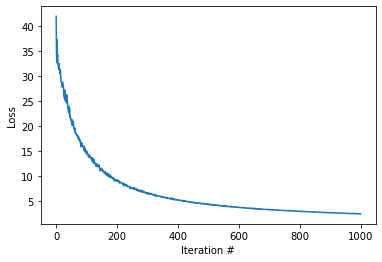

In [31]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

In [32]:
w, b

(tensor([[ 0.2979],
         [-1.9108]], requires_grad=True),
 tensor([-12.9557], requires_grad=True))

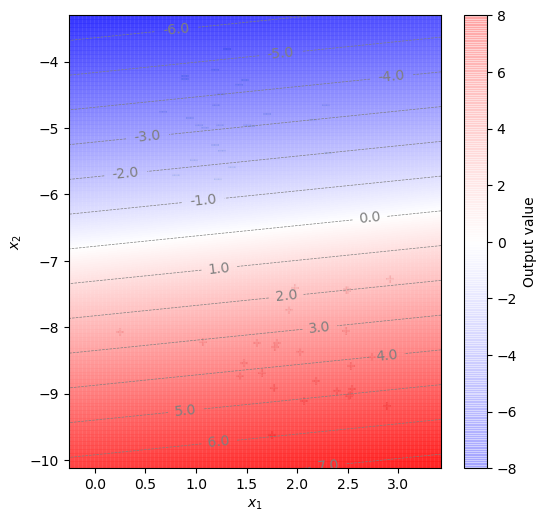

In [33]:
def model(x):
    return x.matmul(w) + b

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.2 Implementation with Sequential

In [34]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single layer NN 
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()

# SGD
lr = 0.1
for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

In [35]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [36]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5753, -2.5298]])),
             ('0.bias', tensor([-17.4721]))])

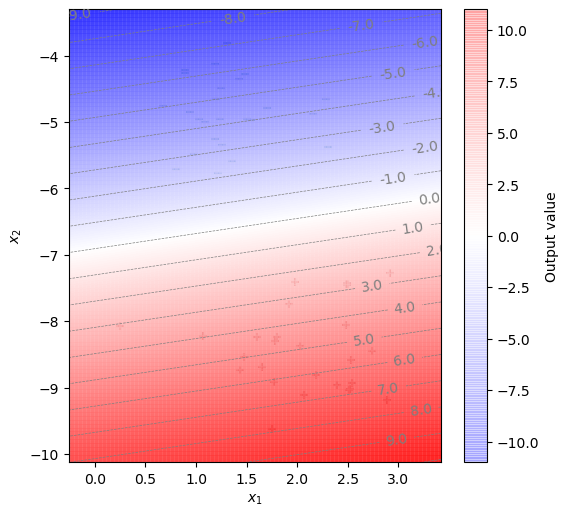

In [37]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.3 Implementation with Sequential and SGD

In [38]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single layer NN 
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

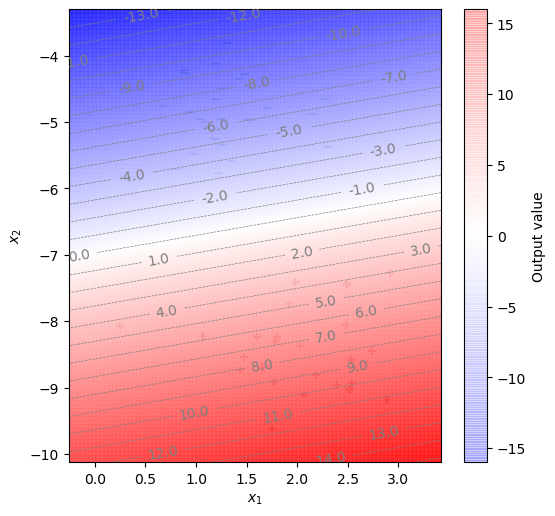

In [39]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 8.2.4 Define NN class

In [40]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define a neural network as a class
class SingleLayerNN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_in, d_out, bias=True)

    def forward(self, x):
        return self.linear1(x) 

model = SingleLayerNN(2, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

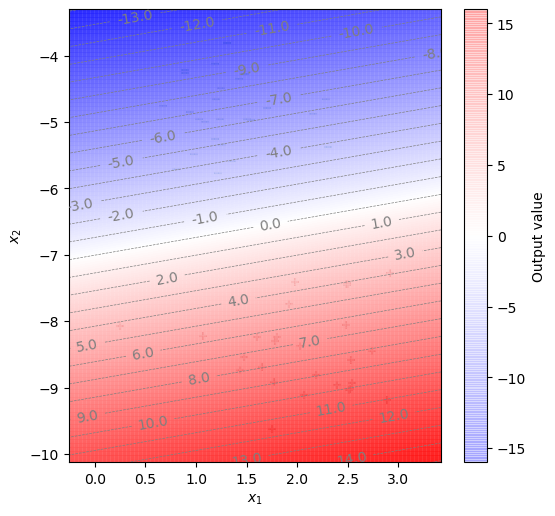

In [41]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

In [42]:
model.state_dict()

OrderedDict([('linear1.weight', tensor([[ 1.0009, -3.7399]])),
             ('linear1.bias', tensor([-26.1969]))])

## 8.3 Multi layer neural network

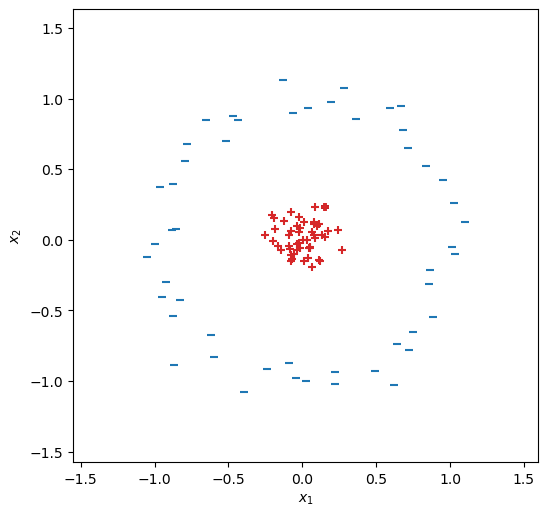

In [43]:
from sklearn.datasets import make_circles

D = make_circles(100, factor=.1, noise=.1, random_state=9)

dtype=torch.float 
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

fig, ax = init_graph(X)
plot_data(ax, X, Y)
plt.show()

### 8.3.1 Single layer NN

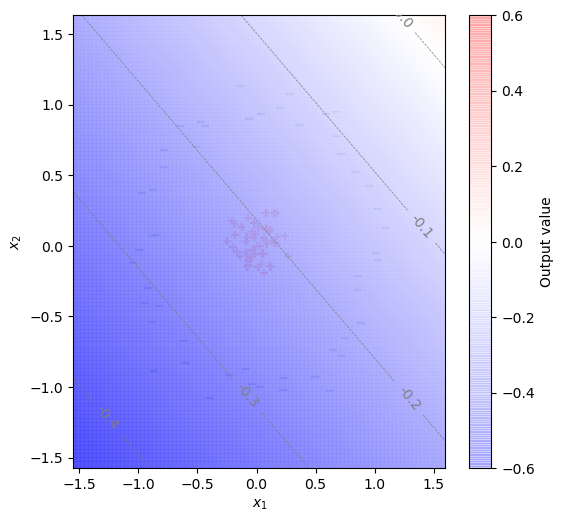

In [44]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model, 0.1)
plt.show()

### 8.3.2 Multi layer NN

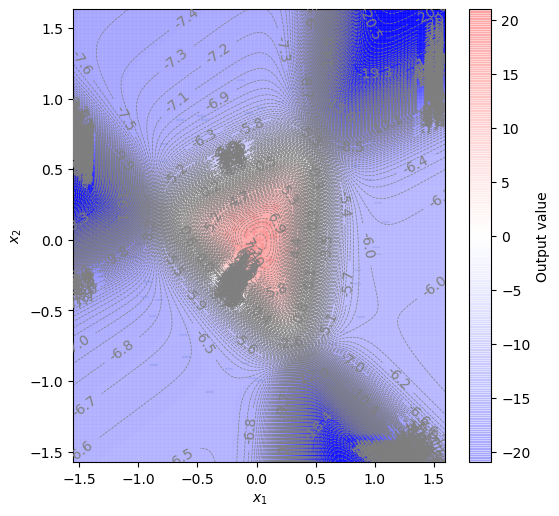

In [45]:
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = torch.nn.Sequential(
    torch.nn.Linear(2, 4, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1, bias=True)
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model, 0.1)
plt.show()

## 8.4 Exercise: automatic differentiation

In [46]:
x = torch.tensor([1, 1], dtype=torch.float)
W = torch.tensor([[1, 1], [-1, 1]], dtype=torch.float, requires_grad=True)
b = torch.tensor([-0.5, 1.5], dtype=torch.float, requires_grad=True)
q = torch.tensor([1, 1], dtype=torch.float, requires_grad=True)
c = torch.tensor(-1.5, dtype=torch.float, requires_grad=True)

In [47]:
loss = -(-torch.dot(torch.addmv(b, W, x).relu(), q).add_(c).sigmoid()).add(1).log()
loss.backward()
print(loss.item())
print(W.grad)
print(b.grad)
print(q.grad)
print(c.grad)

1.7014130353927612
tensor([[0.8176, 0.8176],
        [0.8176, 0.8176]])
tensor([0.8176, 0.8176])
tensor([1.2264, 1.2264])
tensor(0.8176)


## 8.5 Exercise: training NN

### (1) Single layer NN for mnist data

In [48]:
data = np.load('mnist.npz')

print("Training data (X):", data['train_x'].shape, data['train_x'].dtype)
print("Training data (Y):", data['train_y'].shape, data['train_y'].dtype)
print("Test data (X):", data['test_x'].shape, data['test_x'].dtype)
print("Test data (Y):", data['test_y'].shape, data['test_y'].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


In [49]:
# Convert data to tensor

def img_to_vec(X):
    # N * 28 * 28 -> N * 784
    return np.reshape(X, (X.shape[0], -1))

X_train = torch.from_numpy(img_to_vec(data['train_x'])).type(torch.float).to(device)
Y_train = torch.from_numpy(data['train_y']).type(torch.long).to(device)
X_test = torch.from_numpy(img_to_vec(data['test_x'])).type(torch.float).to(device)
Y_test = torch.from_numpy(data['test_y']).type(torch.long).to(device)

In [100]:
dataset = TensorDataset(X_train, Y_train)
loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Single layer NN
model = torch.nn.Sequential(
    torch.nn.Linear(784, 10, bias=True),
    torch.nn.Softmax(dim=1)
)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# History
train_loss_h = []
train_accuracy_h = []
test_loss_h = []
test_accuracy_h = []

for t in range(100):
    for x, y in loader:
        y_hat = model(x)
        # print(y_hat)
        # print(y)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Stats
    Y_train_hat = model(X_train)
    Loss_train = loss_fn(Y_train_hat, Y_train)
    _, Y_train_predicted = torch.max(Y_train_hat, 1)
    Accuracy_train = Y_train_predicted.eq(Y_train).sum() / len(Y_train)
    Y_test_hat = model(X_test)
    Loss_test = loss_fn(Y_test_hat, Y_test)
    _, Y_test_predicted = torch.max(Y_test_hat, 1)
    Accuracy_test = Y_test_predicted.eq(Y_test).sum() / len(Y_test)

    train_loss_h.append(Loss_train.item())
    train_accuracy_h.append(Accuracy_train.item())
    test_loss_h.append(Loss_test.item())
    test_accuracy_h.append(Accuracy_test.item())
    # print(Loss_train.item())
    # print(Accuracy_train.item())
    # print(Loss_test.item())
    # print(Accuracy_test.item())

    if t % 10 == 0:
        print(t)

0
10
20
30
40
50
60
70
80
90


In [101]:
def show_graph(train_loss_h, train_accuracy_h, test_loss_h, test_accuracy_h):
    fig, ax = plt.subplots(2, 1, dpi=100)
    t = np.arange(1, len(train_loss_h)+1)
    ax[0].plot(t, train_loss_h, label='train loss')
    ax[0].plot(t, test_loss_h, label='test loss')
    ax[0].legend()
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('loss')

    ax[1].plot(t, train_accuracy_h, label='train accuracy')
    ax[1].plot(t, test_accuracy_h, label='test accuracy')
    ax[1].legend()
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('accuracy')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

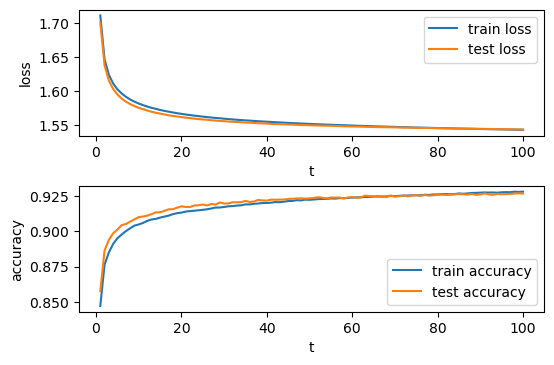

In [102]:
show_graph(train_loss_h, train_accuracy_h, test_loss_h, test_accuracy_h)

### (2)(3) Confusion matrix & precision, recall, f1 score

In [103]:
def confusion_matrix(model, X_test, Y_test):
    cm = np.zeros((10, 10))
    _, Y_test_hat = torch.max(model(X_test), 1)
    for i in range(len(X_test)):
        cm[Y_test_hat[i]][Y_test[i]] += 1
    return cm

In [104]:
cm = confusion_matrix(model, X_test, Y_test)

In [106]:
def show_stats(cm):
    precision_sum = 0
    recall_sum = 0
    f1_score_sum = 0
    # Stats of each category
    for i in range(10):
        precision = cm[i][i] / np.sum(cm[i])
        recall = cm[i][i] / np.sum(cm[:, i])
        f1_score = 2 * precision * recall / (precision + recall)
        precision_sum += precision
        recall_sum += recall
        f1_score_sum += f1_score
        print(f'precision for {i}: {precision}')
        print(f'recall for {i}: {recall}')
        print(f'f1 score for {i}: {f1_score}')
    
    # Macro stats
    print(f'macro precision: {precision_sum / 10}')
    print(f'macro recall: {recall_sum / 10}')
    print(f'macro f1 score: {f1_score_sum / 10}')

In [107]:
show_stats(cm)

precision for 0: 0.9422135161606269
recall for 0: 0.9816326530612245
f1 score for 0: 0.9615192403798102
precision for 1: 0.9770723104056437
recall for 1: 0.9762114537444934
f1 score for 1: 0.9766416923754958
precision for 2: 0.9236180904522613
recall for 2: 0.8905038759689923
f1 score for 2: 0.9067587567834238
precision for 3: 0.922233300099701
recall for 3: 0.9158415841584159
f1 score for 3: 0.9190263288623945
precision for 4: 0.914116485686081
recall for 4: 0.9429735234215886
f1 score for 4: 0.9283208020050124
precision for 5: 0.9143876337693222
recall for 5: 0.8621076233183856
f1 score for 5: 0.8874783612233123
precision for 6: 0.932446264073695
recall for 6: 0.9509394572025052
f1 score for 6: 0.9416020671834625
precision for 7: 0.9306640625
recall for 7: 0.9270428015564203
f1 score for 7: 0.9288499025341131
precision for 8: 0.8813056379821959
recall for 8: 0.9147843942505134
f1 score for 8: 0.8977329974811082
precision for 9: 0.9225280326197758
recall for 9: 0.8969276511397423
f1 s

### (4) Instances that are difficult/easy to predict correct label

In [110]:
def show_instance_img(index, train=True):
    if train:
        x = data['train_x'][index]
        y = data['train_y'][index]
    else:
        x = data['test_x'][index]
        y = data['test_y'][index]

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'Gold label: {y}')
    im = ax.imshow(x)
    fig.colorbar(im)
    plt.show()


def show_six_instances(model, X_test, Y_test):
    # Show 3 instances that are easiest to predict correct label
    # Show 3 instances that are most difficult to predict correct label
    Y_test_predicted = model(X_test)
    _, Y_test_hat = torch.max(Y_test_predicted, 1)

    # softmax = torch.nn.Softmax()
    p_y = np.zeros(len(Y_test))
    p_y_hat = np.zeros(len(Y_test))
    for i in range(len(Y_test)):
        p_y[i] = Y_test_predicted[i][Y_test[i]].item()
        p_y_hat[i] = Y_test_predicted[i][Y_test_hat[i]].item()
        # p_y[i] = softmax(Y_test_predicted[i])[Y_test[i]].item()
        # p_y_hat[i] = softmax(Y_test_predicted[i])[Y_test_hat[i]].item()
    easy = np.argsort(p_y_hat)

    # Easy to predict
    for i in range(1, 4):
        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title(f'Gold label: {Y_test[easy[-i]]}')
        im = ax.imshow(X_test[easy[-i]].numpy().reshape(28, 28))
        fig.colorbar(im)
        plt.show()
        print(f'y: {Y_test[easy[-i]]}')
        print(f'p(y|x): {p_y[easy[-i]]}')
        print(f'y_hat: {Y_test_hat[easy[-i]]}')
        print(f'p(y_hat|x): {p_y_hat[easy[-i]]}')


    # Difficult to predict
    for i in range(3):
        fig = plt.figure(dpi=100)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title(f'Gold label: {Y_test[easy[i]]}')
        im = ax.imshow(X_test[easy[i]].numpy().reshape(28, 28))
        fig.colorbar(im)
        plt.show()
        print(f'y: {Y_test[easy[i]]}')
        print(f'p(y|x): {p_y[easy[i]]}')
        print(f'y_hat: {Y_test_hat[easy[i]]}')
        print(f'p(y_hat|x): {p_y_hat[easy[i]]}')


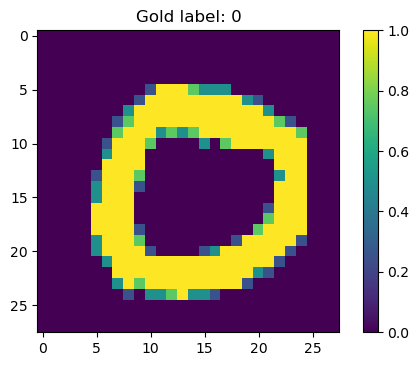

y: 0
p(y|x): 1.0
y_hat: 0
p(y_hat|x): 1.0


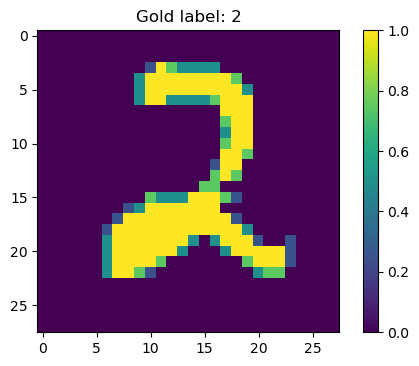

y: 2
p(y|x): 1.0
y_hat: 2
p(y_hat|x): 1.0


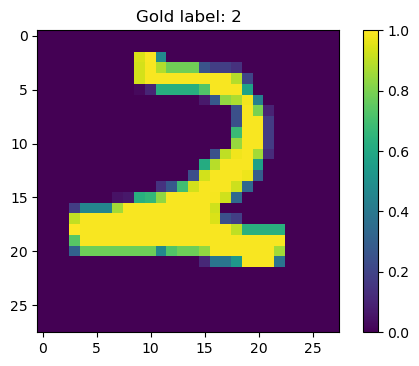

y: 2
p(y|x): 1.0
y_hat: 2
p(y_hat|x): 1.0


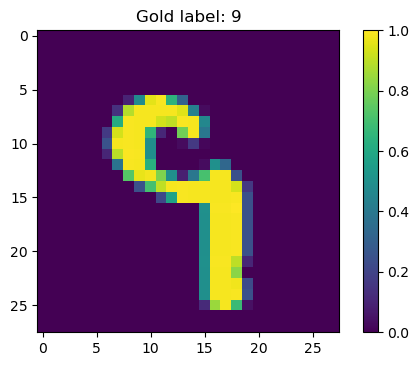

y: 9
p(y|x): 0.3037196695804596
y_hat: 9
p(y_hat|x): 0.3037196695804596


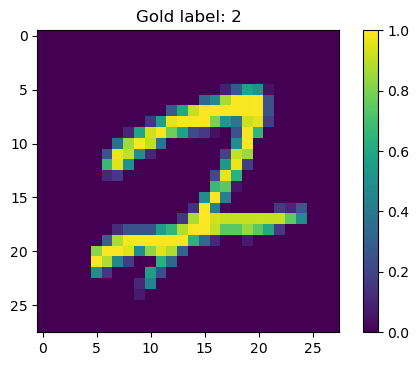

y: 2
p(y|x): 0.3414263129234314
y_hat: 2
p(y_hat|x): 0.3414263129234314


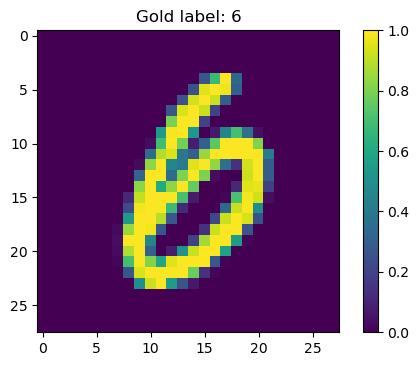

y: 6
p(y|x): 0.3439072072505951
y_hat: 6
p(y_hat|x): 0.3439072072505951


In [111]:
show_six_instances(model, X_test, Y_test)

### (5) Multi layer NN

In [116]:
dataset = TensorDataset(X_train, Y_train)
loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Multi layer NN
model = torch.nn.Sequential(
    torch.nn.Linear(784, 128, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10, bias=True),
    torch.nn.Softmax(dim=1)
)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# History
train_loss_h = []
train_accuracy_h = []
test_loss_h = []
test_accuracy_h = []

for t in range(100):
    for x, y in loader:
        y_hat = model(x)
        # print(y_hat)
        # print(y)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Stats
    Y_train_hat = model(X_train)
    Loss_train = loss_fn(Y_train_hat, Y_train)
    _, Y_train_predicted = torch.max(Y_train_hat, 1)
    Accuracy_train = Y_train_predicted.eq(Y_train).sum() / len(Y_train)
    Y_test_hat = model(X_test)
    Loss_test = loss_fn(Y_test_hat, Y_test)
    _, Y_test_predicted = torch.max(Y_test_hat, 1)
    Accuracy_test = Y_test_predicted.eq(Y_test).sum() / len(Y_test)

    train_loss_h.append(Loss_train.item())
    train_accuracy_h.append(Accuracy_train.item())
    test_loss_h.append(Loss_test.item())
    test_accuracy_h.append(Accuracy_test.item())
    # print(Loss_train.item())
    # print(Accuracy_train.item())
    # print(Loss_test.item())
    # print(Accuracy_test.item())
    if t % 5 == 0:
        print(t)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


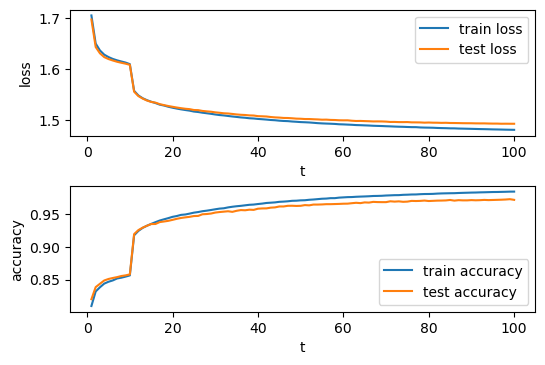

In [117]:
show_graph(train_loss_h, train_accuracy_h, test_loss_h, test_accuracy_h)